***Image Classification*** \\
-- India, Pakistan


PLEASE USE GPU!!! \\
CPU time = 15m    \\
GPU time = 45s

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

**Loading data from Drive** \\
*Augmentations and Normalization for training and validation datasets*

In [ ]:
# DATA AUGMENTATIONS
data_transforms = {
    'train': transforms.Compose([                   #Normalization for training
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([                     #Normalization for validation
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#Accessing dataset from Google Drive. Training data in 'train'. Validation data in 'val'
data_dir = '/content/drive/MyDrive/Colab Notebooks/trainer_model'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')             #Using GPU for faster training

**Visualization of a batch of training data**

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


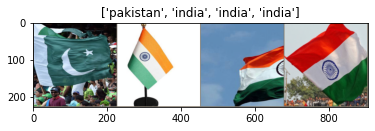

In [ ]:
#Function for visualizing a grid from a batch of training data.
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so all plots are updated


# Get a batch of training data for visualizaiton
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch of training data.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

**Model training**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data. Inputs and labels to GPU
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward propogation
                # track history if only in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward 
                    #optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            #Calculating loss and accuracy at each epoch
            epoch_loss = running_loss / dataset_sizes[phase]            
            epoch_acc = running_corrects.double() / dataset_sizes[phase]   

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    #Best Validation accuracy achieved over num_epochs epochs

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

**Visualization of predictions**

In [ ]:
#Function for displaying model predictions. Displaying 10 predictions.
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)    #inputs to GPU
            labels = labels.to(device)    #labels to GPU

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
             #Display predicted class
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

**Using ConvNet as fixed feature extractor** \\
*Loading pre-trained model (ResNet)*

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False         #freezing the parameters so that the gradients are not computed in backward()

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)    #2 output classes

model_conv = model_conv.to(device)   #model to GPU

criterion = nn.CrossEntropyLoss()    # Cross entropy loss function

# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay Learning Rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

**Training and Evaluation** \\
*This works faster since gradients don't need to be computed for most of the network, in backward. Forward still needs to be calculated.*

In [ ]:
num_epochs = 20
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.7416 Acc: 0.5405
val Loss: 0.6421 Acc: 0.7188

Epoch 1/19
----------
train Loss: 0.7179 Acc: 0.6757
val Loss: 0.4162 Acc: 0.8438

Epoch 2/19
----------
train Loss: 0.4121 Acc: 0.7432
val Loss: 0.3470 Acc: 0.8750

Epoch 3/19
----------
train Loss: 0.4186 Acc: 0.8378
val Loss: 0.3084 Acc: 0.8438

Epoch 4/19
----------
train Loss: 0.3519 Acc: 0.7973
val Loss: 0.2843 Acc: 0.8125

Epoch 5/19
----------
train Loss: 0.4114 Acc: 0.7838
val Loss: 0.3137 Acc: 0.8438

Epoch 6/19
----------
train Loss: 0.7320 Acc: 0.7162
val Loss: 0.2380 Acc: 0.8750

Epoch 7/19
----------
train Loss: 0.4093 Acc: 0.8108
val Loss: 0.4382 Acc: 0.8438

Epoch 8/19
----------
train Loss: 0.2897 Acc: 0.8649
val Loss: 0.3122 Acc: 0.8438

Epoch 9/19
----------
train Loss: 0.2191 Acc: 0.9054
val Loss: 0.2239 Acc: 0.9062

Epoch 10/19
----------
train Loss: 0.4079 Acc: 0.7973
val Loss: 0.4087 Acc: 0.8438

Epoch 11/19
----------
train Loss: 0.3931 Acc: 0.7973
val Loss: 0.2433 Acc: 0.9062

Epoch 12/19
----------
t

**Visualizing model predictions**


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


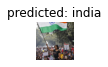

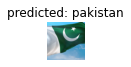

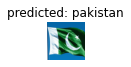

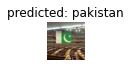

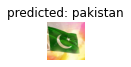

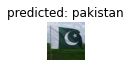

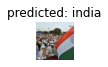

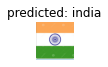

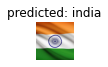

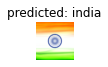

In [ ]:
visualize_model(model_conv)
#Displaying 10 model predictions
plt.ioff()
plt.show()

--------------------------------------------------------------------------------

*Pending:* \\
- Train model on all 8 classes
- Webcam predictions? Click pic from webcam. OpenCV, VideoCapture(0)

..Torchvision doesn't use opencv. Ask if slight change in project proposal is okay